In [1]:
%load_ext watermark
%watermark -v -p sklearn,numpy,scipy,matplotlib

CPython 3.5.4
IPython 6.2.1

sklearn 0.19.1
numpy 1.13.3
scipy 1.0.0
matplotlib 2.1.0


In [2]:
%matplotlib inline
from preamble import *

## 알고리즘 체인과 파이프라인

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [4]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.95


### 데이터 전처리와 매개변수 선택

In [5]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'gamma': 1, 'C': 1}


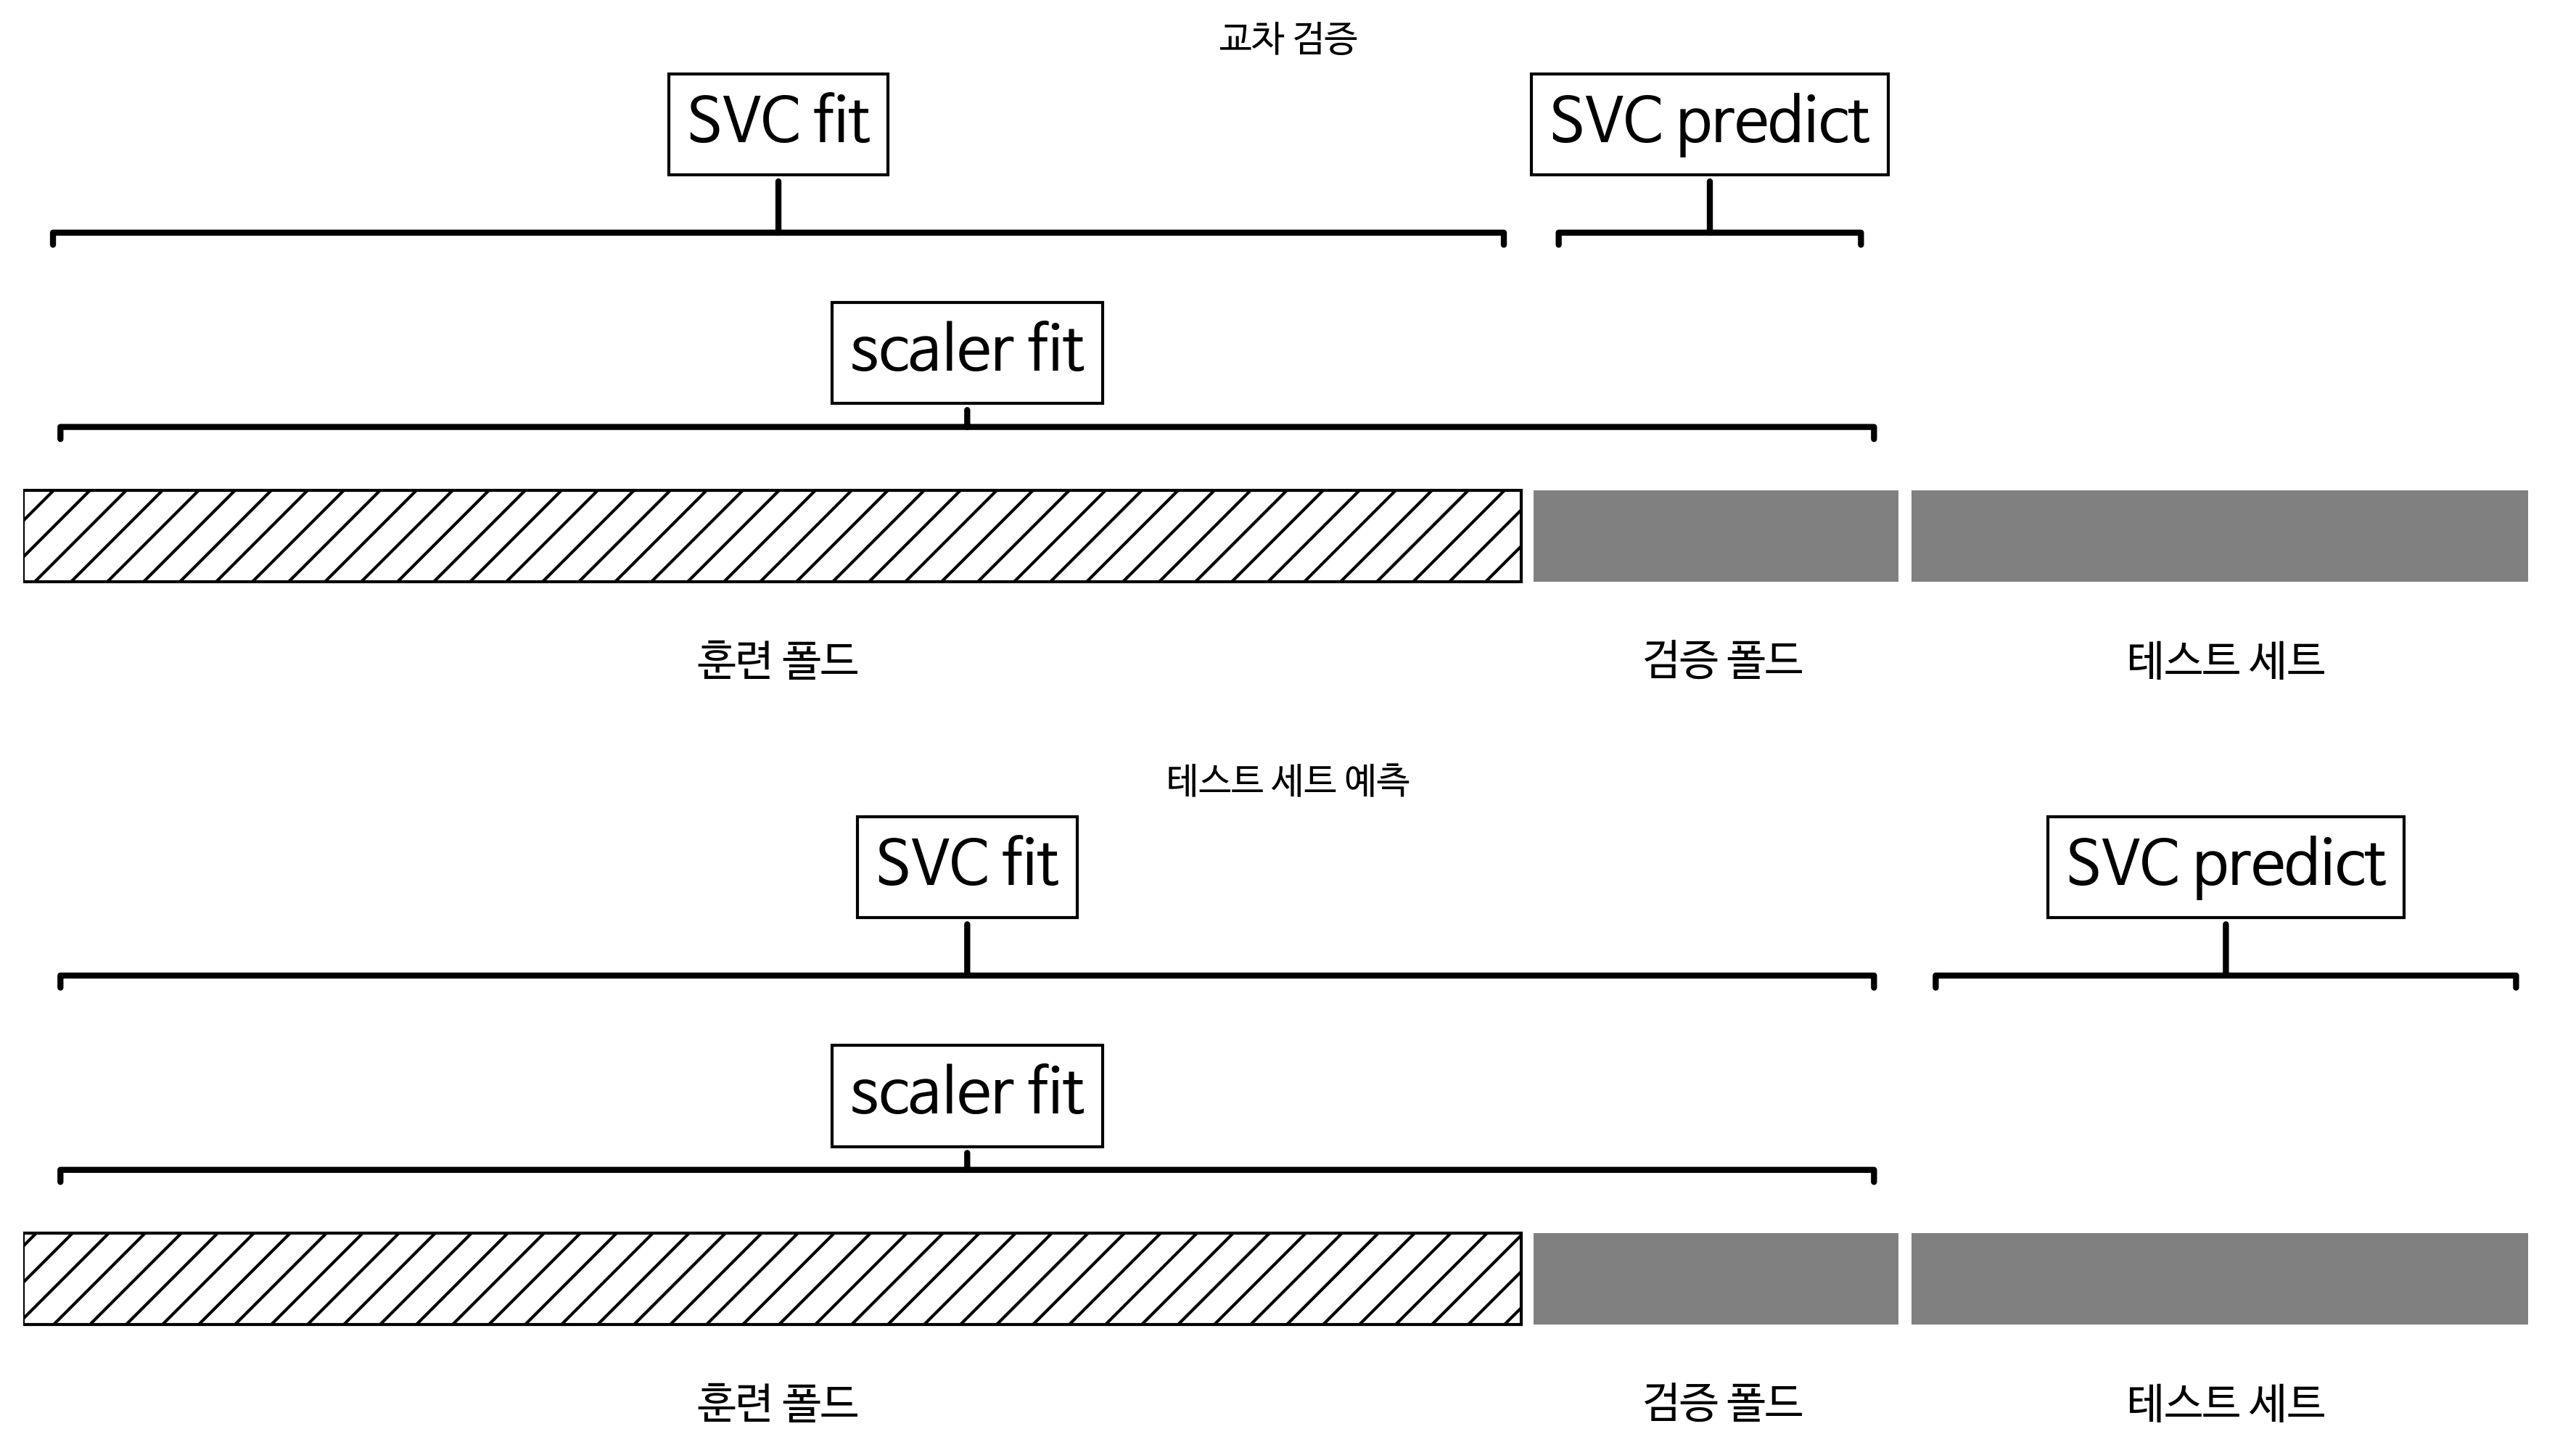

In [6]:
mglearn.plots.plot_improper_processing()

### 파이프라인 구축하기

In [7]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [8]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [9]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.95


### 그리드 서치에 파이프라인 적용하기

In [10]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [11]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__gamma': 1, 'svm__C': 1}


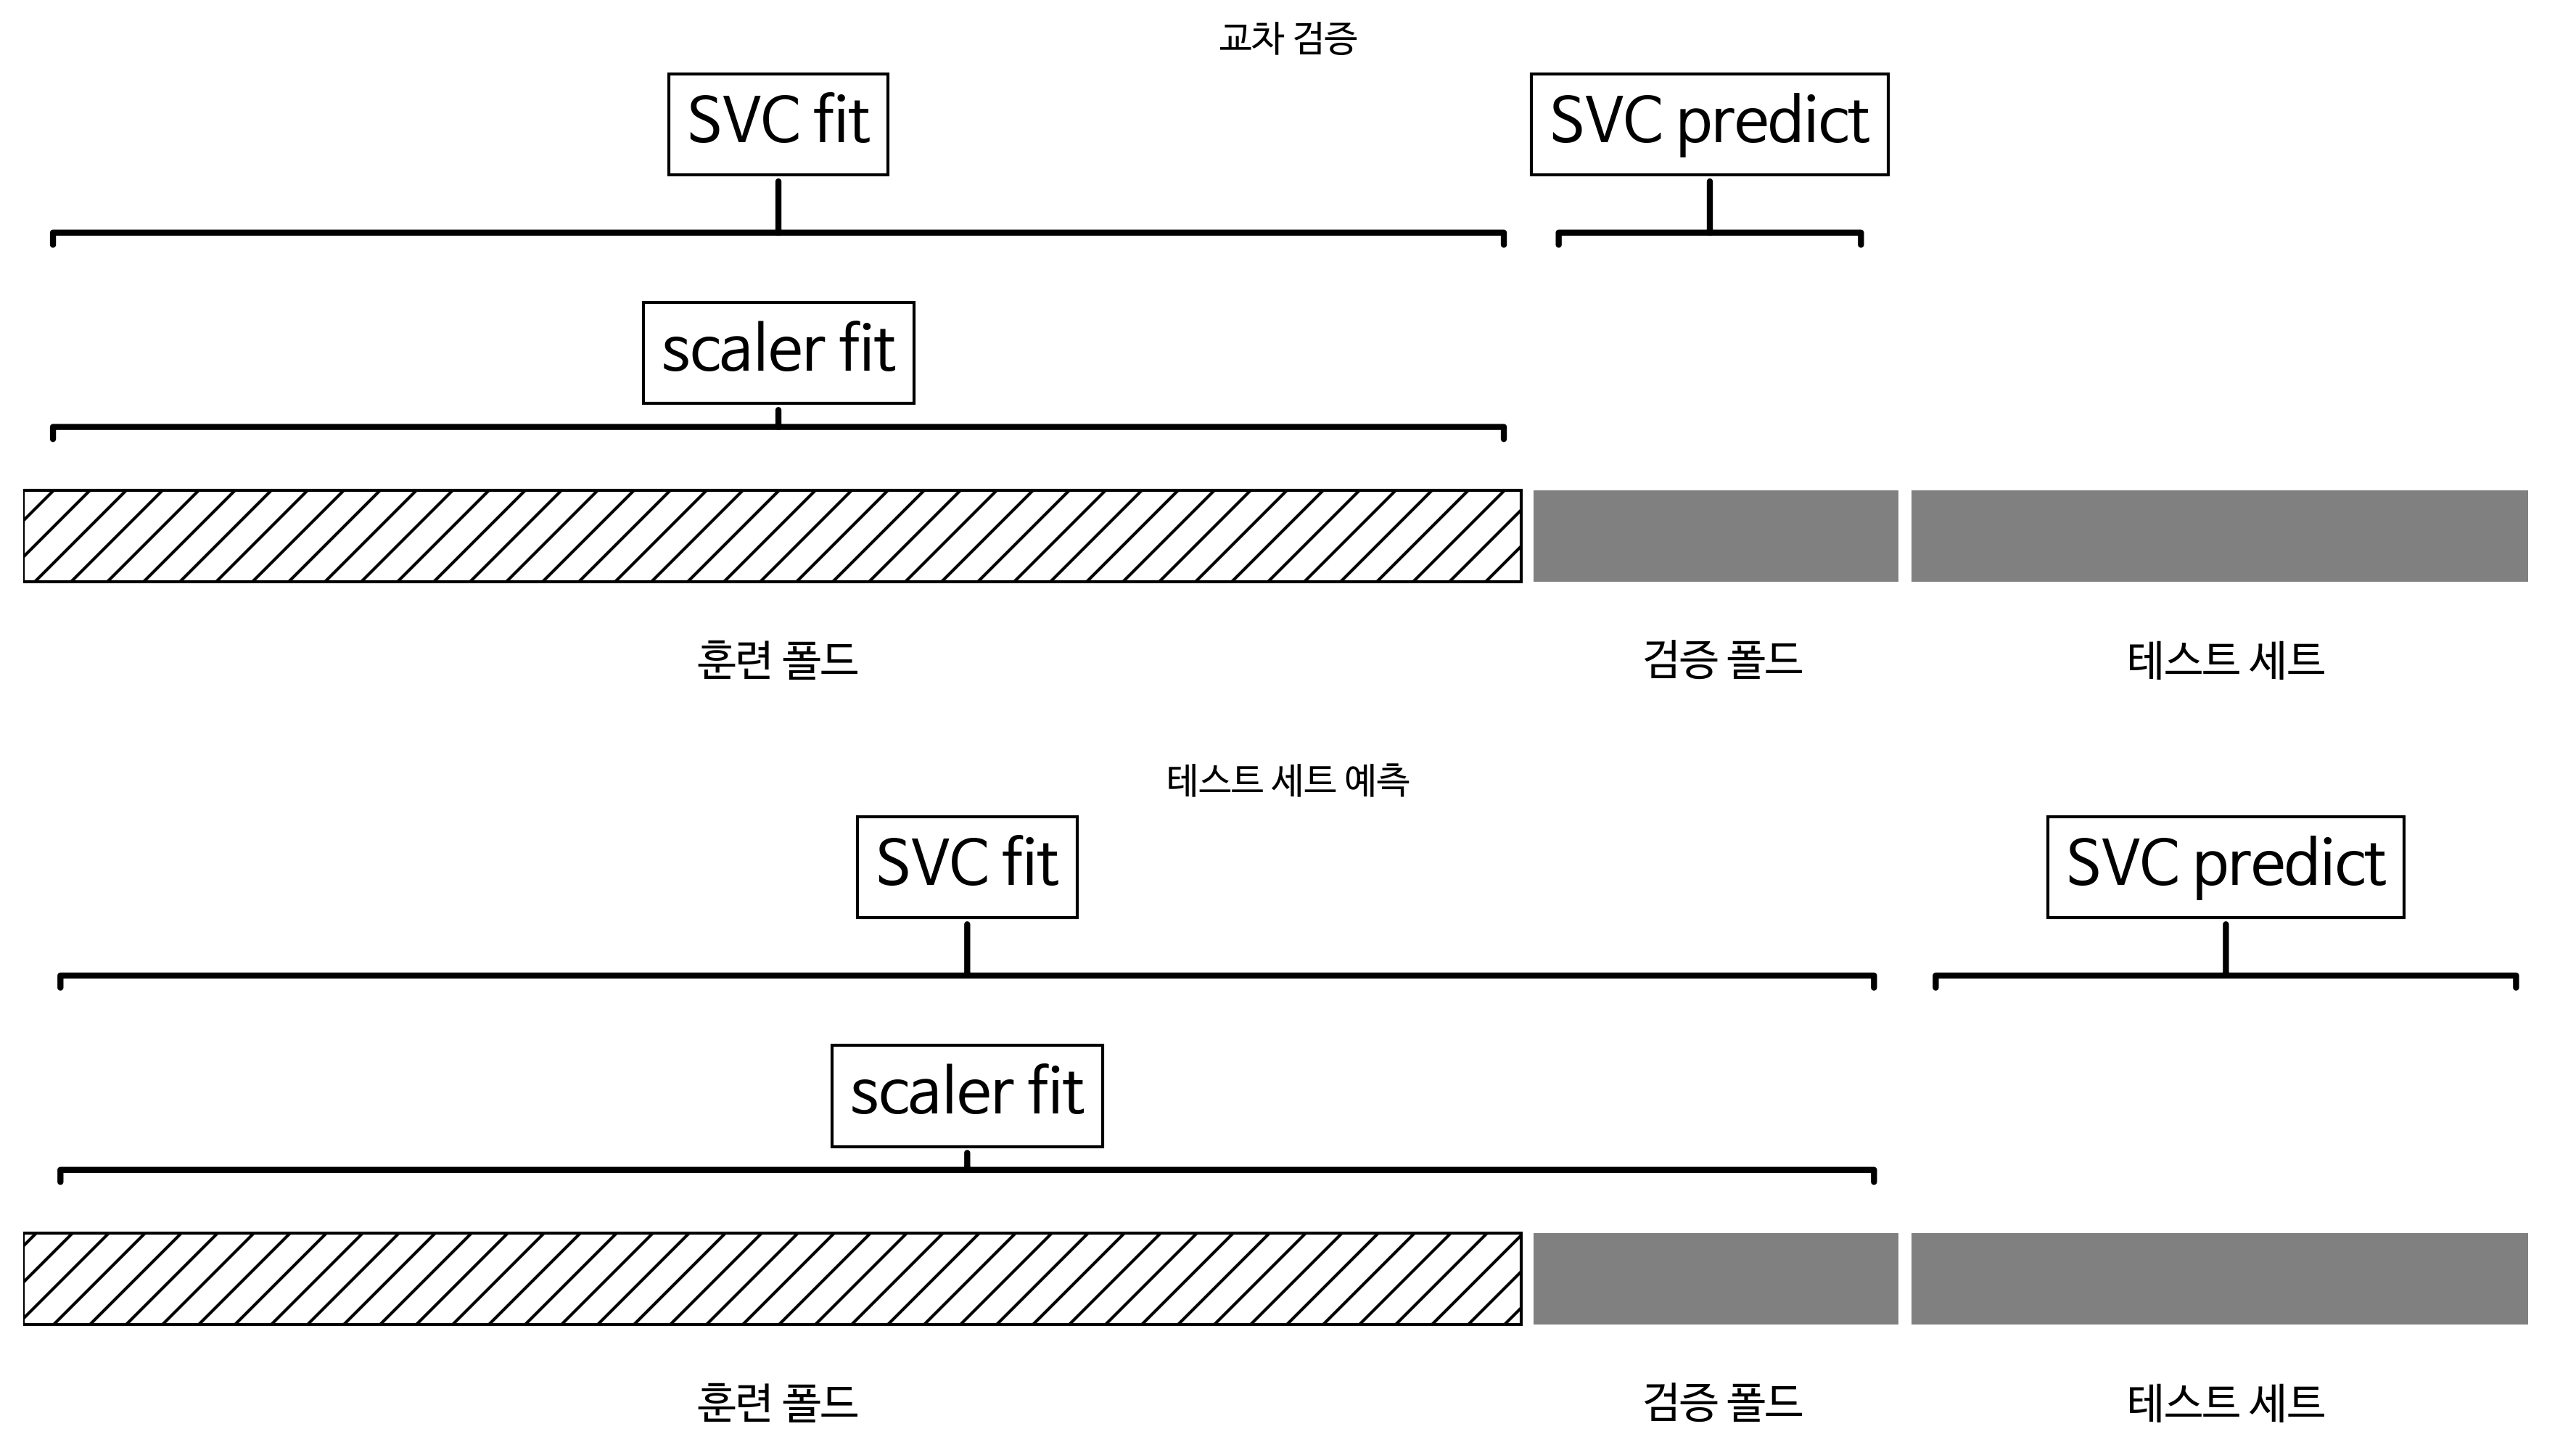

In [12]:
mglearn.plots.plot_proper_processing()

In [13]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [14]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (릿지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수 (릿지): 0.91


In [16]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수 (파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수 (파이프라인): -0.25


### 파이프라인 인터페이스

In [17]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [18]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

#### `make_pipleline`을 사용한 파이프라인 생성

In [19]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [20]:
print("파이프라인 단계:\n{}".format(pipe_short.steps))

파이프라인 단계:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n{}".format(pipe.steps))

파이프라인 단계:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


#### 단계 속성에 접근하기

In [22]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### 그리드 서치 안의 파이프라인의 속성에 접근하기

In [23]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [24]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
print("최상의 모델:\n{}".format(grid.best_estimator_))

최상의 모델:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [27]:
print("로지스틱 회귀 단계:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

로지스틱 회귀 단계:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [28]:
print("로지스틱 회귀 계수:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

로지스틱 회귀 계수:
[[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


### 전처리와 모델의 매개변수를 위한 그리드 서치

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [30]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [31]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

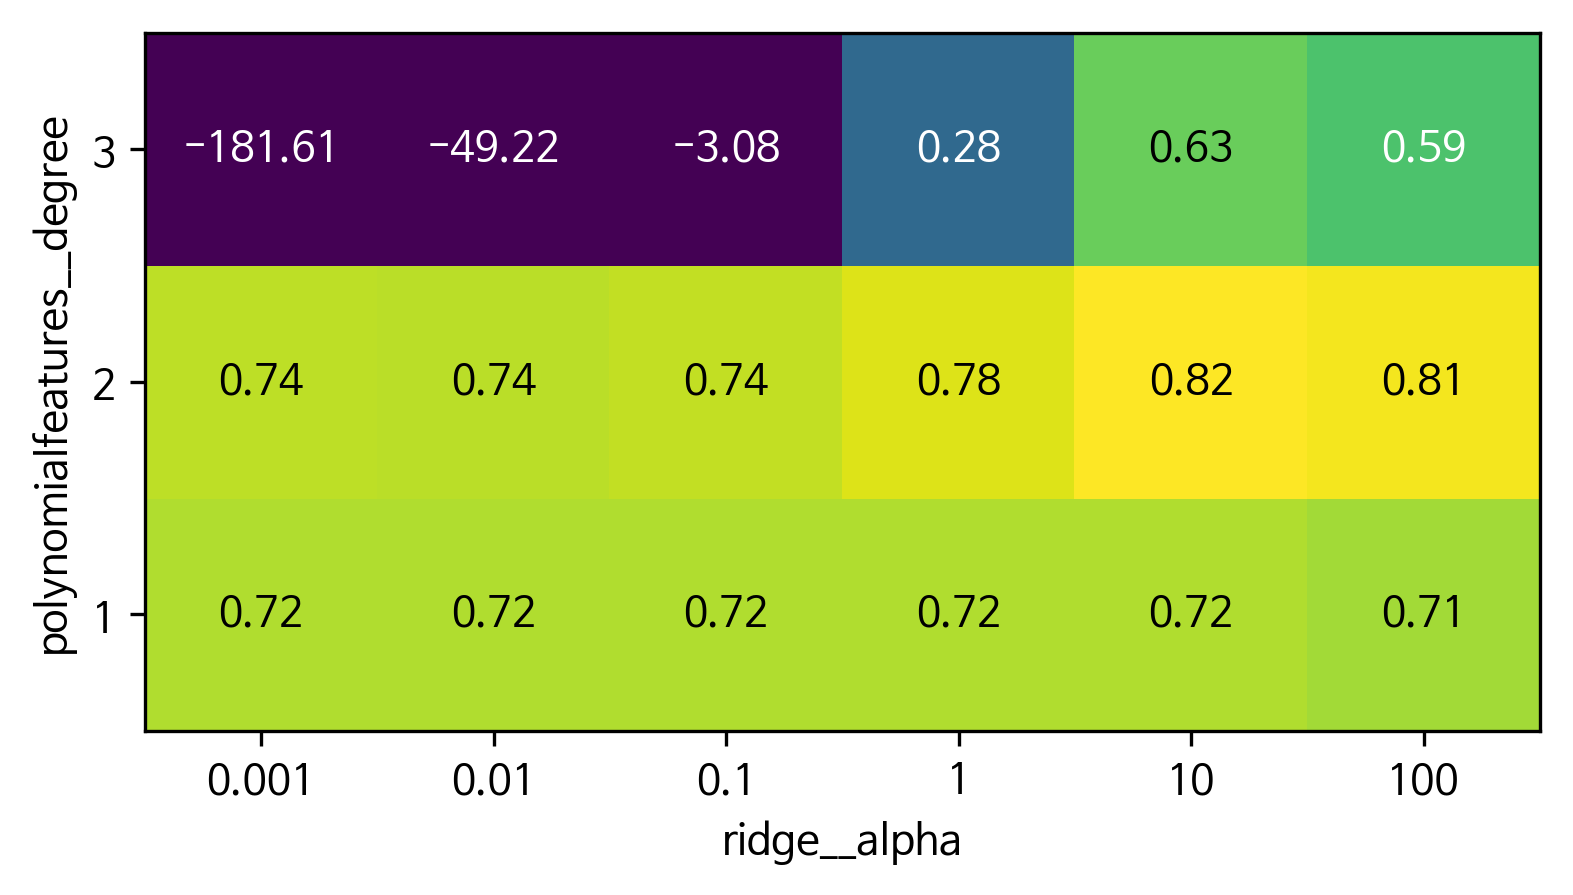

In [32]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [33]:
print("최적의 매개변수: {}".format(grid.best_params_))

최적의 매개변수: {'ridge__alpha': 10, 'polynomialfeatures__degree': 2}


In [34]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [35]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


### 모델 선택을 위한 그리드 서치

In [36]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [37]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier__C': 10}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


### 요약 및 정리